# 情報処理実習Ⅱ：眼球運動データ
この演習では眼球運動データを処理していきます。
Moodle にアップロードされた実験書も参考にしてください。（アップロードしたファイルにも含めておきました。）

眼球運動はタイムスタンプごとに測定したデータが出力されます。したがって、１行ずつ視線位置や提示されていた画像などの情報が記録されています。

データは .tsv ファイルで出力されますが、事前にcsvファイルに変換してあります。（この際、使用するデータ列だけにしてあります。）

データ形式は、行が時系列、列が各情報です。
（実際にGoogleスプレッドシートで開いてみましょう。）
Googleスプレッドシートで中身を確認できますが、測定点が多すぎて扱いにくいです。
従って、どのようなデータなのかを理解してプログラムで処理をしたほうがよいでしょう。


## アップロードしたファイルの構造
[フォルダ]
*   data: 各被験者の実験データが保存されているフォルダ。
*   Metrics: 各被験者のAOI解析されたデータが保存されているフォルダ。
*   misc: 参考資料が保存されているフォルダ。
*   stimuli: 実験で使用した画像が保存されているフォルダ。

[ファイル]
*   CorrectAnswer.csv: 実験中の正答が記録されたcsvファイル。
*   Demo_analysis.ipynb: 今開いているGoogle Colab.ファイル。解析方法の説明やプログラムについて説明してある。
*   results_example.csv: 解析結果を記録するcsvファイル。1行に1名の被験者の結果を記録していきます。
*   情報処理実習2_実験書.pdf: 今回の演習の実験書。このGoogle Colab ファイルと合わせて読んでください。



## 計測データ

眼球運動計測装置は大量の情報を出力してくれます。しかし、多すぎるので事前に今回の演習に必要な情報に絞っておきました。（ついでに、csvファイルに変換しました。）
実際のデータは "./data" フォルダにあります。

今回使用するデータラベルは下記の通りです。

* Recording timestamp: レコード中のタイムスタンプ [$\mu$s]
* Recording date: レコード月日
* Participant name: 被験者名
* Recording duration: 総レコード時間 [ms]
* Recording resolution height: データ分解能（高さ） [pix]
* Recording resolution width: データ分解能（幅） [pix]
* Average calibration accuracy (pixels): キャリブレーション正確度 [pix]
* Average calibration precision SD (pixels): キャリブレーション精度 [pix]
* Event: イベント（キーボード押し、刺激呈示など）
* Event value: イベント詳細（どのキーボード入力か？どの刺激呈示か？など）
* Gaze point X: 視線位置（X方向）左上が [0, 0]
* Gaze point Y: 視線位置（Y方向）
* Presented Media name: 提示されていたメディア名（画像ファイル名など）
* Eye movement type: 眼球運動の分類
 * Fixation: 固視
 * Saccade: サッケード（見たい物を網膜中心で捉えるための急速眼球運動）
 * EyesNotFound: 眼球が観測てきていない（瞬きやキャリブレーション精度が悪いために生じる）



In [ ]:
# ライブラリのインポート
import pandas as pd

# google ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#----- データ読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。

# csvファイルをロード
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス
df.head()

## 被験者応答
今回の実験ではキーボード応答を使用してフィッシングメールかどうか判断してもらいました。

* フィッシングメールではない（怪しくない）と思ったら左（Left）
* フィッシングメール（怪しい）と思ったら右（Right）

計測データから該当箇所を抽出して被験者のパフォーマンスを計算してみましょう。
このとき、正答率だけでなく、下記のような分類表も作成しましょう。
表の用語の意味は、今回の実験では下記の通りです。
* Hit: フィッシングメールを、正しく「怪しい」と判断
* False Alarm: フィッシングメールではないメールを、間違って「怪しい」と判断
* Miss: フィッシングメールを、間違って「怪しくない」と判断
* Correct Rejection: フィッシングメールを、正しく「怪しい」と判断


表: 被験者応答の分類

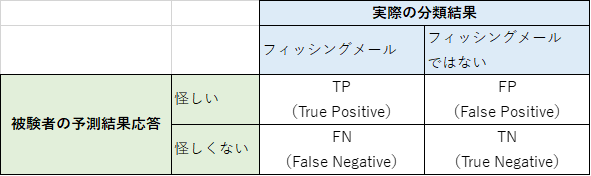



代表的な評価指標を計算してみましょう。**計算結果は各被験者ごとにGoogleスプレッドシート(results_example.csv)に記録しておきましょう。**

正答率 (Accuracy)
$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$

適合率 (Precision)
$$ Precision = \frac{TP}{TP + FP} $$

再現率（Recall）
$$ Recall = \frac{TP}{TP + FN}$$

F値（F-measure）
$$ F = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$

### 関数 getKeyResponse(GazeDataFrame)
被験者応答を抽出する関数 getKeyResponse( ) を用意しましたので使ってください。

In [ ]:
'''getKeyResponse(GazeDataFrame)
入力された GazeDataFrame から被験者応答に相当する部分（Event value）を抽出して返す。

入力：
    GazeDataFrame...TobiiProにより計測されたデータを pandas で読み込んだもの

出力
    Response...被験者応答一覧。Series型で返す。

USAGE:
#-----
import pandas as pd

df = pd.read_csv('ID000_DataExport.csv')    # ファイルパスは自分の環境に合わせて変更すべし。
Response = getKeyResponse(df)

print(Response)
#-----
'''
def getKeyResponse(GazeDataFrame):
    # 被験者応答 Event = 'KeyboardEvent' を抽出
    # 'Event value' にキー名がある。
    tmp = GazeDataFrame[GazeDataFrame['Event'].isin(['KeyboardEvent'])]
    Response = tmp[1:16]['Event value'].values # 最初と最後の Space キーは実験開始・終了なので除外

    return Response

In [ ]:
''' getKeyResponse( ) の使い方
'''
#----- データ読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。

# csvファイルをロード
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス
Response = getKeyResponse(df)

print(Response)

#
# 注意！
# 被験者によっては実験中にSpaceなどを押してしまった方もいます。
# そのようなデータは解析対象外にしておきましょう。
#

In [ ]:
#-------------------------------------------------------------------------------
# 課題1：被験者の応答結果について、パフォーマンスを計算せよ。
#
# 被験者応答と正答データ "CorrectAnswer.csv" を比較して
# 正答率とHit, False Alarm, Miss, Correct Rejectionの数を計算しましょう。
#-------------------------------------------------------------------------------
# 被験者データ読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

# 被験者応答抽出
Response = getKeyResponse(df)

# 正答データを読み込む
tmp = pd.read_table("/content/drive/My Drive/Class_EyeTracking/CorrectAnswer.csv")
Correct = tmp['Correct Answer'].values

#----- あとは Response と Correct を比較して分類すればいいですね。どちらも Series 型になっています。 -----#


## TOI
[計測データの可視化]

実験データには視線の時系列データも記録されています。
実際に計測データを可視化してみましょう。
使用するのは、

* Gaze Point X ... 視線のディスプレイ上でのX座標
* Gaze Point Y ... 視線のディスプレイ上でのY座標
* Presented Media name ... 提示されていた画像。

です。



## データ切り出し（TOI）
実験中に興味がある時間帯を「Time of Interest (TOI)」と呼びます。

今回の実験では、メールを観察している時間帯の視線位置に興味があります。しかし、データにはそれ以外のデータも記録されているため、データをTOIで切り出す必要があります。

今回使用した刺激画像のファイル名は下記の通りです。

*   01_Kyoumu_T.png
*   02_Amazon2_F.png
*   03_Amazon3_F.png
*   04_Rakuten2_F.png
*   05_ticket_T.png
*   06_Rakuten_F.png
*   07_Rakuten_T.png
*   08_yodobasi_F.png
*   09_Apple_F.png
*   10_Kankou_T.png
*   11_LINE_F.png
*   12_Kyufu2_F.png
*   13_ponta_T.png
*   14_Kyufu_F.png
*   15_SMBC_F.png

ファイル名は

「呈示の順番\_メール概要\_正答.png」

になっています。

### 関数 getTOI(GazeDataFrame, PresentedMediaName)
TOIを切り出す関数を用意しました。

In [ ]:
''' getTOI(GazeDataFrame, PresentedMediaName)
入力された GazeDataFrame から PresentedMediaName をキーとしてTOIを抽出して返す。

入力：
    GazeDataFrame...DataFrame型。TobiiProにより計測されたデータを pandas で読み込んだもの
    PresentedMediaName...String型。実験中に呈示されていた画像ファイル名。GazeDataFrameに含まれているモノを指定すること

出力
    TOI...抽出されたTOI。DataFrame型。

USAGE:
#-----
import pandas as pd

df = pd.read_csv('ID000_DataExport.csv')    # ファイルパスは自分の環境に合わせて変更すべし。
MediaName = '01_Kyoumu_T.png'   # 呈示画像のファイル名を指定
TOI = getTOI(df, MediaName)

TOI.head()
#-----

'''
def getTOI(GazeDataFrame, MediaName):
    TOI = GazeDataFrame[GazeDataFrame['Presented Media name'].isin([MediaName])]
    return TOI

In [ ]:
#----- 念のため、再度データ読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。

# csvファイルをロード
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス
df.head()

#----- データ切り出し
MediaName = '01_Kyoumu_T.png' # どの画像を見ていたか。この名前を変えれば他のTOIを抽出できる。

# 01_Kyoumu_T.png を呈示していたTOIを抽出
TOI = getTOI(df, MediaName)
TOI.head()


In [ ]:
# Recording timestamp [micro sec]からTOIの長さ（duration）を計算
#***** duration は被験者パフォーマンスやメールとどのような関係があるでしょうか？
TOI_start = TOI['Recording timestamp'].iloc[1]
TOI_end = TOI['Recording timestamp'].iloc[-1]
Duration = (TOI_end - TOI_start)/1000000  # micro sec から sec に変換
print(Duration, '[秒]')

## 視線位置のプロット
刺激画像の上に視線位置をプロットしてみましょう。

In [ ]:
#-------------------------------------------------------------------------------
# 課題2-1：視線位置のプロット
#-------------------------------------------------------------------------------

# ライブラリインポート
import pandas as pd
import matplotlib.pyplot as plt
import cv2

#----- 被験者応答読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。
# csvファイルをロード
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

# TOI抽出
MediaName = '01_Kyoumu_T.png' # TOIのキー。この名前を変えれば他のTOIを抽出できる。
TOI = getTOI(df, MediaName)

# 視線位置の X, Y を取得。この値を使ってプロットする。
GazeX = TOI['Gaze point X']
GazeY = TOI['Gaze point Y']

# 刺激画像の読み込み; 実際に呈示されていた刺激は 01_Kyoumu_T_Stim.png といったファイル名になっている。
img_bgr = cv2.imread('/content/drive/My Drive/Class_EyeTracking/stimuli/' + MediaName[:-4] + '_Stim.png')
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 画像の表示
plt.imshow(img)
plt.plot(GazeX, GazeY, 'r.-')
plt.show()


## ヒートマップ作製
前述の視線位置の可視化は時系列で視線位置をプロットしていました。それでは、実験中の視線位置はどのような分布をしていたのでしょうか？これを可視化するのがヒートマップです。

ヒートマップを作成することで、画像のどこを主に観ていたのかがわかります。（その代わり、最初にどこを観たのか？といった時系列情報は失われてしまいます。）

ヒートマップ作製方法

1. 実際の呈示刺激と同じ画像配列をゼロで初期化します。
2. 記録された視線位置の [X, Y] を取り出します。
3. [2.] で取り出した [X, Y] に相当する画素の値をインクリメントします。
4. [2.] -> [3.] を記録されたデータ数分繰り返します。
5. [4.] の結果に対して平滑化フィルタ（ガウスぼかし）を適用します。

後は、画像表示するために、

*   画像を正規化する
*   画像を0～255にする
*   カラーマップとしてJETを適用する

をすればOKです。





In [ ]:
#-------------------------------------------------------------------------------
# 課題2-2: ヒートマップの作製
#-------------------------------------------------------------------------------

#----- 演習 -----#
import numpy as np
import matplotlib.pyplot as plt
import cv2

#0. ----- TOI 抽出して、視線位置を可視化
# 被験者応答読み込み
ID = 'ID000'  # 被験者名; ここを変えれば他の被験者データの処理もできる。
# csvファイルをロード
df = pd.read_csv("/content/drive/My Drive/Class_EyeTracking/data/" + ID + "_DataExport.csv") #実験データへのパス

# TOI抽出
MediaName = '01_Kyoumu_T.png' # TOIのキー。この名前を変えれば他のTOIを抽出できる。
TOI = getTOI(df, MediaName)

# 視線位置の X, Y を取得。この値を使ってプロットする。
GazeX = TOI['Gaze point X']
GazeY = TOI['Gaze point Y']

# 刺激画像の読み込み; 実際に呈示されていた刺激は 01_Kyoumu_T_Stim.png といったファイル名になっている。
img_bgr = cv2.imread('/content/drive/My Drive/Class_EyeTracking/stimuli/' + MediaName[:-4] + '_Stim.png')
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)


# 1. ----- 画像配列初期化
imSize = img.shape
heatmap = np.zeros([imSize[0], imSize[1]], dtype = 'float32')
gazeNum = 0

# 2.～4. ----- 視線位置が記録された画素をインクリメント
for i in range(len(GazeX)):
  # 視線位置が記録されていれば処理（Eyes Not Found の場合もあるので。）
  if not( np.isnan(GazeX.iloc[i]) ) :
    xx = int(GazeX.iloc[i])
    yy = int(GazeY.iloc[i])
    heatmap[yy, xx] = heatmap[yy, xx] + 1

# 5. ----- ぼかしを適用
# 標準偏差=50pixのガウス分布を使用
# ガウス分布が0に漸近するのに十分なカーネルサイズを指定; 標準偏差の4倍あればOK
heatmap_blur = cv2.GaussianBlur(heatmap, (201,201), 50)
# 画像を 0-1 に正規化
MAX = np.max(heatmap_blur)  # 最大値
MIN = np.min(heatmap_blur)  # 最小値
heatmap_blur = (heatmap_blur - MIN)/(MAX - MIN) # 正規化

#----- 表示するための作業
# ヒートマップをRGBに変換
heatmap_rgb = np.uint8(255 * heatmap_blur)
# JETのカラーマップを適用
heatmap_rgb = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
# RGBに変換
heatmap_rgb = cv2.cvtColor(heatmap_rgb, cv2.COLOR_BGR2RGB)

# ヒートマップ表示
plt.imshow(heatmap_rgb, 'jet')
plt.colorbar()


In [ ]:
#----- 演習の続き。 -----#
# ヒートマップと元の画像を重ねる
# 0.4はヒートマップの強度係数
superimposed_img = heatmap_rgb*0.4 + img
superimposed_img = superimposed_img/np.max(superimposed_img)

# 画像を表示
fig = plt.figure()
plt.imshow(superimposed_img)

# 保存
filename = 'heatmap_' + MediaName + '.png'
plt.savefig(filename)

## AOI

視線が呈示刺激のどこにいたのか？を解析するのが Area Of Interest (AOI) です。アップロードした "./Metrics" フォルダに被験者ごとに保存されています。

今回の実験では電子メールの

*   差出人などのヘッダー（Header）
*   受信日時（HeaderTime）
*   署名などのフッター（Footer）
*   本文中のURL（URL; メールによって最大でURL4まである）

にAOIを設定しました。

**今回は解析方針として、下記の3項目があります。**

*  AOIにはいくつか種類がありますが、今回は「Total_duration_of_fixations」という
データラベルを使用します。

  *  Total_duration_of_fixations: AOIの範囲を固視していた長さ [ms]

*  AOIは各画像ごとに設定する必要があったため、他の画像のAOIは欠損値となっています。（つまり、空白になっている。）

*  URLに関しては複数のAOIが存在するが一つにまとめたい。

従って、


1. 「Total_duration_of_fixations」の列を抽出する

2.  欠損値を除去する

3.  AOIがURLの場合は加算する

という処理が必要です。

最終的な処理結果のイメージは下記の通りです。

表：AOI解析結果

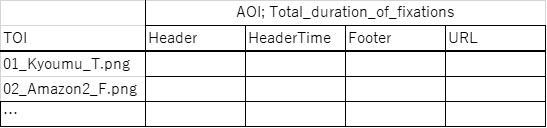

In [ ]:
#----- AOI解析
# 念のためライブラリインポートとドライブマウントをする。
import numpy as np
import pandas as pd

# google ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#-------------------------------------------------------------------------------
# 課題3：AOIの解析
#-------------------------------------------------------------------------------

# 各被験者のデータ読み込み
ID = 'ID000'
raw = pd.read_table('/content/drive/My Drive/Class_EyeTracking/Metrics/' + ID + '_Metrics.tsv')

cutLabels = []  # 抽出するデータラベルを保存するリスト
for label in raw.columns:
  # if文で特定の文字列を含む列を抽出
  if label.find('Total_duration_of_fixations')\
    != -1 or label.find('Duration_of_interval')\
      != -1 or label.find('TOI') != -1:
    cutLabels.append(label) # リストに追加

# データを抽出
df = raw[cutLabels]
df.head()

In [ ]:
#-------------------------------------------------------------------------------
# 課題3：被験者1名のAOI時間を、画像刺激間で平均する。
#-------------------------------------------------------------------------------

NUM = 15  # 呈示刺激の数; 今回は 15なので 15+1=16
TOI = raw['TOI'].iloc[0:NUM]  # TOIを初期化; rawデータから引っ張ってくる
res = np.zeros([NUM, 4])

# TOIでloop 処理
for i in range(NUM):  
  print(df['TOI'].iloc[i])  # 解析するTOIを表示; debug用
  # 計算用変数の初期化
  Header = 0
  HeaderTime = 0
  Footer = 0
  URL = 0

  tmp = df[i:i+1].dropna(how="all", axis=1) #欠損値（NaN）を含むデータラベルを除外
  TOTAL = np.array(tmp['Duration_of_interval'].values)

  # データラベルで loop 処理
  for label in tmp.columns:
    # データラベルが Header で終わる列を抽出
    if label.endswith('Header') == 1:
      #print(label)
      Header = Header + tmp[label].values
    # データラベルが HeaderTime で終わる列を抽出
    if label.endswith('HeaderTime') == 1:
      #print(label)
      HeaderTime = HeaderTime + tmp[label].values
    # データラベルが Footer で終わる列を抽出
    if label.endswith('Footer'):
      #print(label)
      Footer = Footer + tmp[label].values
    # データラベルに URL を含む列を抽出
    if label.find('URL') != -1:
      #print(label)
      URL = URL + tmp[label].values

  '''  
  #結果表示; debug用
  print(Header)
  print(HeaderTime)
  print(Footer)
  print(URL)
  '''
  # 結果を格納
  calc = np.array([Header, HeaderTime, Footer, URL]) / TOTAL  #TOTALで割って正規化
  res[i,:] = calc.reshape(1,4)

# DataFrame として統合
df_sum = pd.DataFrame(res, 
                      columns = ['Header', 'HeaderTime', 'Footer', 'URL'],
                      index = TOI)
df_sum

In [ ]:
#-------------------------------------------------------------------------------
# 課題3：処理結果の表示
#-------------------------------------------------------------------------------
df_sum.mean()
# 各AOIの平均を、被験者パフォーマンスを記録したスプレッドシートに追記しましょう。

#*****
# 実際のところ、Footerが設定された画像が少ないので 0 の場合はNaNにしたほうがよさそう。
#*****

↑の課題3の処理結果を results_example.csv に記録しておいてください。
次の相関解析で使用します。

## 相関解析

被験者パフォーマンスとAOIの結果が集計できた。この2つのデータからフィッシングメールを区別するときに重要な情報を検討する。方法は、



1.   横軸を被験者パフォーマンス、縦軸をAOIとして散布図を作成
2.   1.の組み合わせについて、相関係数を算出する。

である。強い正の相関が見られれば、被験者パフォーマンスが高くなるほどAOIを観ていた時間が長いと考えられる。



In [ ]:
#-------------------------------------------------------------------------------
# 課題4：相関解析
#-------------------------------------------------------------------------------

#----- 相関解析
import numpy as np
import pandas as pd
import seaborn as sns

# google ドライブのマウント
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Class_EyeTracking/results_example.csv')

In [ ]:
# 横軸を F値、縦軸をAOIにしてプロット
df.plot.scatter('F-measure', 'Header')
df.plot.scatter('F-measure', 'HeaderTime')
df.plot.scatter('F-measure', 'Footer')
df.plot.scatter('F-measure', 'URL')

In [ ]:
# 相関係数の算出
df.corr()